In [ ]:
# --- Install dependencies (Colab) ---
import sys, subprocess, pkg_resources

def pip_install(args):
    print("Installing:", ' '.join(args))
    return subprocess.check_call([sys.executable, "-m", "pip", "install", *args])

try:
    import torch
except Exception:
    pip_install(["torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cpu"])
    import torch

torch_v = torch.__version__.split('+')[0]
print("Torch:", torch.__version__)

# Install PyG wheels compatible with the Torch version
wurl = f"https://data.pyg.org/whl/torch-{torch_v}+cpu.html"
to_install = [
    "torch_geometric",
    "torch_scatter",
    "torch_sparse",
    "torch_cluster",
]
pip_install([*to_install, "-f", wurl])

pip_install(["scikit-learn", "pandas", "matplotlib", "networkx", "numpy"])

/tmp/ipython-input-2924517861.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess, pkg_resources


Torch: 2.8.0+cu126
Installing: torch_geometric torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
Installing: scikit-learn pandas matplotlib networkx numpy


0

In [ ]:
# ---------- Setup: CUDA memory + libs ----------
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

import os, gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
from torch_geometric.loader import LinkNeighborLoader
import matplotlib.pyplot as plt


# Make runs reproducible-ish
torch.manual_seed(42); np.random.seed(42)
torch.set_float32_matmul_precision("high")
use_amp = True  # flip to False if NaNs

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
CSV_PATH = '/content/paysim.csv'
assert os.path.exists(CSV_PATH), f"Not found: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)

need = {'step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig',
        'nameDest','oldbalanceDest','newbalanceDest','isFraud'}
missing = need - set(df.columns)
assert not missing, f"Missing columns: {missing}"




In [ ]:
SUBSET = 500_000
if len(df) > SUBSET:
    strat_labels = df['isFraud'].values
    _, sub_idx = train_test_split(np.arange(len(df)), test_size=SUBSET, stratify=strat_labels, random_state=42)
    df = df.iloc[sub_idx].reset_index(drop=True)


In [ ]:

# ---------- Build graph ----------
accounts = pd.Index(pd.unique(pd.concat([df['nameOrig'], df['nameDest']], ignore_index=True)))
acc2id = {a:i for i,a in enumerate(accounts)}

src = df['nameOrig'].map(acc2id).astype(np.int64).values
dst = df['nameDest'].map(acc2id).astype(np.int64).values
edge_index = torch.from_numpy(np.vstack([src, dst]))

# Edge attr (transaction features)
type_ohe = pd.get_dummies(df['type'], prefix='type')
edge_feats = pd.DataFrame({
    'amount': df['amount'].astype(float),
    'step': df['step'].astype(int),
    'deltaOrg': (df['oldbalanceOrg'] - df['newbalanceOrig']).astype(float),
    'deltaDest': (df['newbalanceDest'] - df['oldbalanceDest']).astype(float),
    'flagged': df.get('isFlaggedFraud', 0).astype(int),
})
edge_feats = pd.concat([edge_feats, type_ohe], axis=1)

scaler = StandardScaler()
for c in ['amount','step','deltaOrg','deltaDest']:
    edge_feats[c] = scaler.fit_transform(edge_feats[[c]])

edge_attr = torch.from_numpy(edge_feats.values.astype(np.float32))
edge_label = torch.from_numpy(df['isFraud'].astype(int).values)

# Node features: simple degrees (extend as needed)
num_nodes = len(accounts)
deg_in  = np.bincount(dst, minlength=num_nodes)
deg_out = np.bincount(src, minlength=num_nodes)
node_x = torch.from_numpy(np.vstack([np.log1p(deg_in), np.log1p(deg_out)]).T.astype(np.float32))

# Edge splits
idx = np.arange(len(edge_label))
tr, te = train_test_split(idx, test_size=0.2, stratify=edge_label.numpy(), random_state=42)
tr, va = train_test_split(tr, test_size=0.2, stratify=edge_label.numpy()[tr], random_state=42)
train_mask = torch.zeros(len(idx), dtype=torch.bool); train_mask[tr] = True
val_mask   = torch.zeros(len(idx), dtype=torch.bool); val_mask[va] = True
test_mask  = torch.zeros(len(idx), dtype=torch.bool); test_mask[te] = True

data = Data(x=node_x, edge_index=edge_index, edge_attr=edge_attr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
edge_label = edge_label.to(device); train_mask=train_mask.to(device); val_mask=val_mask.to(device); test_mask=test_mask.to(device)

In [ ]:
print("Train fraud ratio:", edge_label[train_mask].float().mean().item())
print("Val fraud ratio:", edge_label[val_mask].float().mean().item())
print("Test fraud ratio:", edge_label[test_mask].float().mean().item())


Train fraud ratio: 0.001290624961256981
Val fraud ratio: 0.0012875000247731805
Test fraud ratio: 0.001289999927394092


In [ ]:
pos = int(edge_label[train_mask].sum().item()); neg = int(train_mask.sum().item()) - pos
pos_weight = torch.tensor([neg / max(pos,1)], device=device)
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

@torch.no_grad()
def eval_logits(logits, mask, y_true):
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    m = mask.detach().cpu().numpy()
    yt = y_true.detach().cpu().numpy()[m]
    pr_auc = average_precision_score(yt, probs[m])
    prec, rec, thr = precision_recall_curve(yt, probs[m])
    f1 = 2*prec*rec/(prec+rec+1e-12); bi = f1.argmax()
    t = thr[bi-1] if bi>0 else 0.5
    yp = (probs[m] >= t).astype(int)
    rep = classification_report(yt, yp, digits=4)
    return float(pr_auc), float(t), rep

In [ ]:
class EdgeGNN(nn.Module):
    def __init__(self, in_node, in_edge, hid=64, conv_type='sage', heads=4):
        super().__init__()
        # Choose convolution type
        if conv_type == 'sage':
            self.conv1 = SAGEConv(in_node, hid)
            self.conv2 = SAGEConv(hid, hid)
            self.out_dim = hid * 2 + in_edge
        elif conv_type == 'gcn':
            self.conv1 = GCNConv(in_node, hid)
            self.conv2 = GCNConv(hid, hid)
            self.out_dim = hid * 2 + in_edge
        elif conv_type == 'gat':
            # For GAT, we add heads and concatenate output
            self.conv1 = GATConv(in_node, hid // heads, heads=heads)
            self.conv2 = GATConv(hid, hid // heads, heads=heads)
            self.out_dim = hid * 2 + in_edge
        else:
            raise ValueError(f"Unknown conv_type '{conv_type}'. Use 'sage', 'gcn' or 'gat'.")

        self.mlp = nn.Sequential(
            nn.Linear(self.out_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        s, d = data.edge_index
        h = torch.cat([x[s], x[d], data.edge_attr], dim=1)
        return self.mlp(h).squeeze(-1)


In [ ]:
pure = EdgeGNN(in_node=data.x.size(1), in_edge=data.edge_attr.size(1), conv_type='gat').to(device) ## please note to change the GNN variant change the conv_type
opt = torch.optim.Adam(pure.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
EPOCHS = 100
for e in range(1, EPOCHS+1):
    pure.train(); opt.zero_grad()
    logit = pure(data)
    loss = bce(logit[train_mask], edge_label[train_mask].float())
    loss.backward(); nn.utils.clip_grad_norm_(pure.parameters(), 1.0); opt.step()
    if e==1 or e%5==0:
        pure.eval()
        with torch.no_grad():
            lv = pure(data)
        pr, t, _ = eval_logits(lv, val_mask, edge_label)
        print(f"[PURE] Ep{e:02d} loss={loss.item():.4f} | val PR-AUC={pr:.4f}")

pure.eval()
with torch.no_grad():
    lt = pure(data)
pr, t, rep = eval_logits(lt, test_mask, edge_label)
print("\n[PURE] Test PR-AUC:", round(pr,4), "| thr:", round(t,4))
print(rep)

[PURE] Ep01 loss=1.3753 | val PR-AUC=0.4883
[PURE] Ep05 loss=1.2569 | val PR-AUC=0.5109
[PURE] Ep10 loss=1.1559 | val PR-AUC=0.4979
[PURE] Ep15 loss=1.0676 | val PR-AUC=0.4736
[PURE] Ep20 loss=0.9852 | val PR-AUC=0.4605
[PURE] Ep25 loss=0.9065 | val PR-AUC=0.4605
[PURE] Ep30 loss=0.8279 | val PR-AUC=0.4705
[PURE] Ep35 loss=0.7668 | val PR-AUC=0.4836
[PURE] Ep40 loss=0.7249 | val PR-AUC=0.4935
[PURE] Ep45 loss=0.6937 | val PR-AUC=0.5000
[PURE] Ep50 loss=0.6574 | val PR-AUC=0.5071
[PURE] Ep55 loss=0.6322 | val PR-AUC=0.5126
[PURE] Ep60 loss=0.6123 | val PR-AUC=0.5179
[PURE] Ep65 loss=0.5708 | val PR-AUC=0.5226
[PURE] Ep70 loss=0.5467 | val PR-AUC=0.5266
[PURE] Ep75 loss=0.5227 | val PR-AUC=0.5302
[PURE] Ep80 loss=0.5084 | val PR-AUC=0.5333
[PURE] Ep85 loss=0.4860 | val PR-AUC=0.5359
[PURE] Ep90 loss=0.4724 | val PR-AUC=0.5379
[PURE] Ep95 loss=0.4573 | val PR-AUC=0.5405
[PURE] Ep100 loss=0.4324 | val PR-AUC=0.5424

[PURE] Test PR-AUC: 0.5497 | thr: 0.988
              precision    recall 


[PURE] Test PR-AUC: 0.5497 | Threshold: 0.9880
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     99871
           1     0.8406    0.4496    0.5859       129

    accuracy                         0.9992    100000
   macro avg     0.9199    0.7248    0.7927    100000
weighted avg     0.9991    0.9992    0.9991    100000



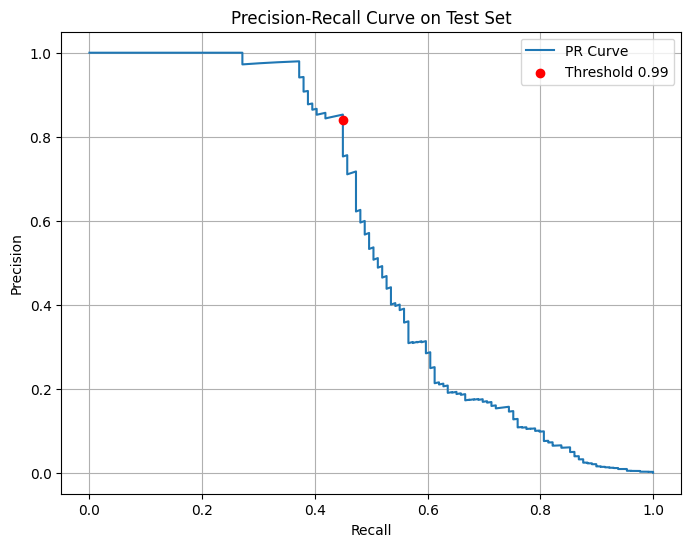

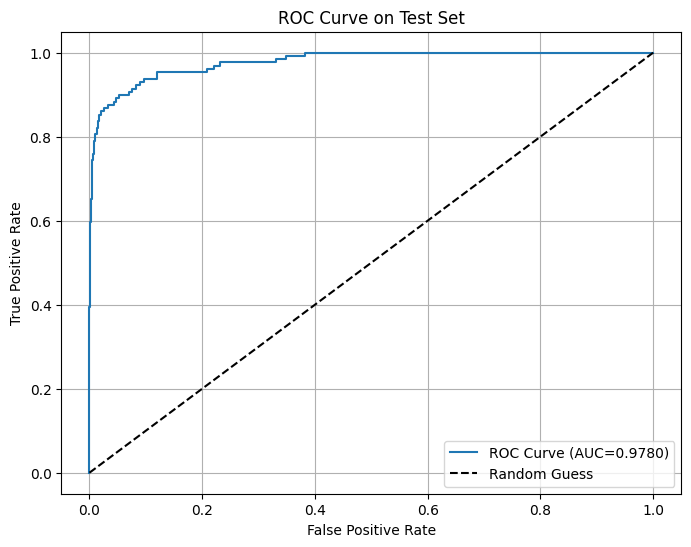

ROC Curve AUC = 0.9780


In [ ]:
conv_type = 'gat'

pr, thr, rep = eval_logits(lt, test_mask, edge_label)
print(f"\n[PURE] Test PR-AUC: {pr:.4f} | Threshold: {thr:.4f}")
print(rep)

# Plot PR and ROC curves on test set
probs = torch.sigmoid(lt[test_mask]).cpu().numpy()
y_true = edge_label[test_mask].cpu().numpy()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, probs)
idx = (np.abs(thresholds - thr)).argmin()

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='PR Curve')
plt.scatter(recall[idx], precision[idx], color='red', label=f'Threshold {thr:.2f}', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test Set')
plt.legend()
plt.grid(True)
plt.savefig(f'{conv_type}_precision_recall_curve_paysim.png')
  # Save image
plt.show()


# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true, probs)
roc_auc = roc_auc_score(y_true, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend()
plt.grid(True)
plt.savefig(f'{conv_type}_roc_curve_paysim.png')  # Save image
plt.show()

print(f'ROC Curve AUC = {roc_auc:.4f}')



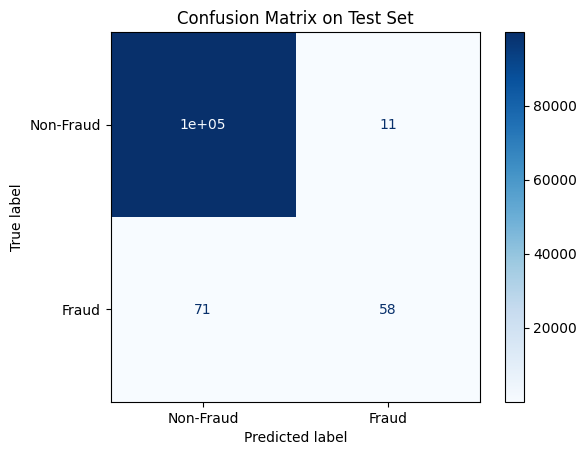

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (probs >= thr).astype(int)
conv_type = 'gat'

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.savefig(f'{conv_type}confusion_matrix_paysim.png')  # Save image
plt.show()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")


True Negatives: 99855
False Positives: 16
False Negatives: 70
True Positives: 59


In [ ]:
fraud_count_test = edge_label[test_mask].sum().item()
print(f"Number of fraud samples in test set: {fraud_count_test}")


Number of fraud samples in test set: 129
